In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import IPython
import IPython.display

import seaborn as sns
from matplotlib import rcParams

import scipy
from scipy import io
from scipy.interpolate import interp1d
import os

from scipy.io import loadmat
from tqdm import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore")

In [2]:


def scaled_data2(input_list):

    global_min = np.nanmin([np.nanmin(traj) for traj in input_list])
    global_max = np.nanmax([np.nanmax(traj) for traj in input_list])

    if global_max == global_min:
        raise ValueError("All trajectories have the same constant value; scaling is not possible.")
    
    normalized_list = []

    for np_array in input_list:
        output_array = 2 * ((np_array - global_min) / (global_max - global_min)) - 1

        #output_array -= output_array[0]

        #range_factor = max(1, np.max(np.abs(output_array)))
        #output_array /= range_factor

        normalized_list.append(output_array)

    return normalized_list, global_max, global_min

def process_paths(path_matrix):
    n_path = path_matrix.shape[1]
    labels = np.zeros((1, n_path))
    paths_cleaned = path_matrix.copy()

    for tidx in range(n_path):
        inv = len(np.where(paths_cleaned[1:, tidx] == 0)[0])
        path_tmp = paths_cleaned[:-(inv), tidx]

        last_5_percent = int(len(path_tmp) * 0.05)
        mean_last_5 = round(np.mean(path_tmp[-last_5_percent:]), 3)
        labels[0, tidx] = 1 if mean_last_5 < 0 else 0

        paths_cleaned[1:, tidx] = np.where(paths_cleaned[1:, tidx] == 0, 0, paths_cleaned[1:, tidx])

    paths_cleaned_t = [np.array(col[~np.isnan(col)]) for col in paths_cleaned.T]
    
    return  paths_cleaned_t

def create_recent_points_data(X,  window_size):
    X_windows = []

    for i in range(X.shape[0]):  
        trajectory = X[i]
        invis = len(np.where(trajectory == 0)[0])-1
        trajectory_non_zero = trajectory[:-invis]
        # last point in window_size 
        window = trajectory_non_zero[-window_size:]
        X_windows.append(window)
    return np.array(X_windows)

In [3]:
from tensorflow.keras.models import load_model
model_combined_full = load_model('DUAL_LSTM_MODEL.keras')

In [2]:
def get_file_type(file_path):
    if "iid_same" in file_path:
        return "iid_same"
    elif "iid_opposite" in file_path:
        return "iid_opposite"
    elif "rdw_same" in file_path:
        return "rdw_same"
    elif "rdw_opposite" in file_path:
        return "rdw_opposite"
    else:
        return "other"

In [38]:
data_csv =  sorted(str(p) for p in pathlib.Path("../data/new_path_2").glob("*.csv"))
sorted_files = sorted(data_csv, key=get_file_type)
data_csv_iid_op = [file for file in sorted_files if get_file_type(file) == "iid_opposite"]
data_csv_iid_same = [file for file in sorted_files if get_file_type(file) == "iid_same"]
data_csv_rdw_op = [file for file in sorted_files if get_file_type(file) == "rdw_opposite"]
data_csv_rdw_same = [file for file in sorted_files if get_file_type(file) == "rdw_same"]

data_sim_iid_op = [pd.read_csv(file, header=None, sep =';').to_numpy() for file in data_csv_iid_op][0:46]
data_sim_iid_same = [pd.read_csv(file, header=None, sep =';').to_numpy() for file in data_csv_iid_same][0:46]
data_sim_rdw_op = [pd.read_csv(file, header=None, sep =';').to_numpy() for file in data_csv_rdw_op][0:46]
data_sim_rdw_same = [pd.read_csv(file, header=None, sep =';').to_numpy() for file in data_csv_rdw_same][0:46]

In [9]:
data = scipy.io.loadmat('../data/trajectories.mat')
    
    # Path
iid = data['iidind'][3:,]
rdw = data['rdwind'][3:,]

iid_same_old = np.hstack((iid[:,0:50], iid[:,150:]))
iid_opp_old = iid[:,50:150]

rdw_same_old = np.hstack((rdw[:,0:50], rdw[:,150:]))
rdw_opp_old = rdw[:,50:150]

In [85]:
rdw_same_new = data_sim_rdw_same[10]
rdw_op_new= data_sim_rdw_op[10]
    
iid_same_new = data_sim_iid_same[10]
iid_op_new= data_sim_iid_op[10]

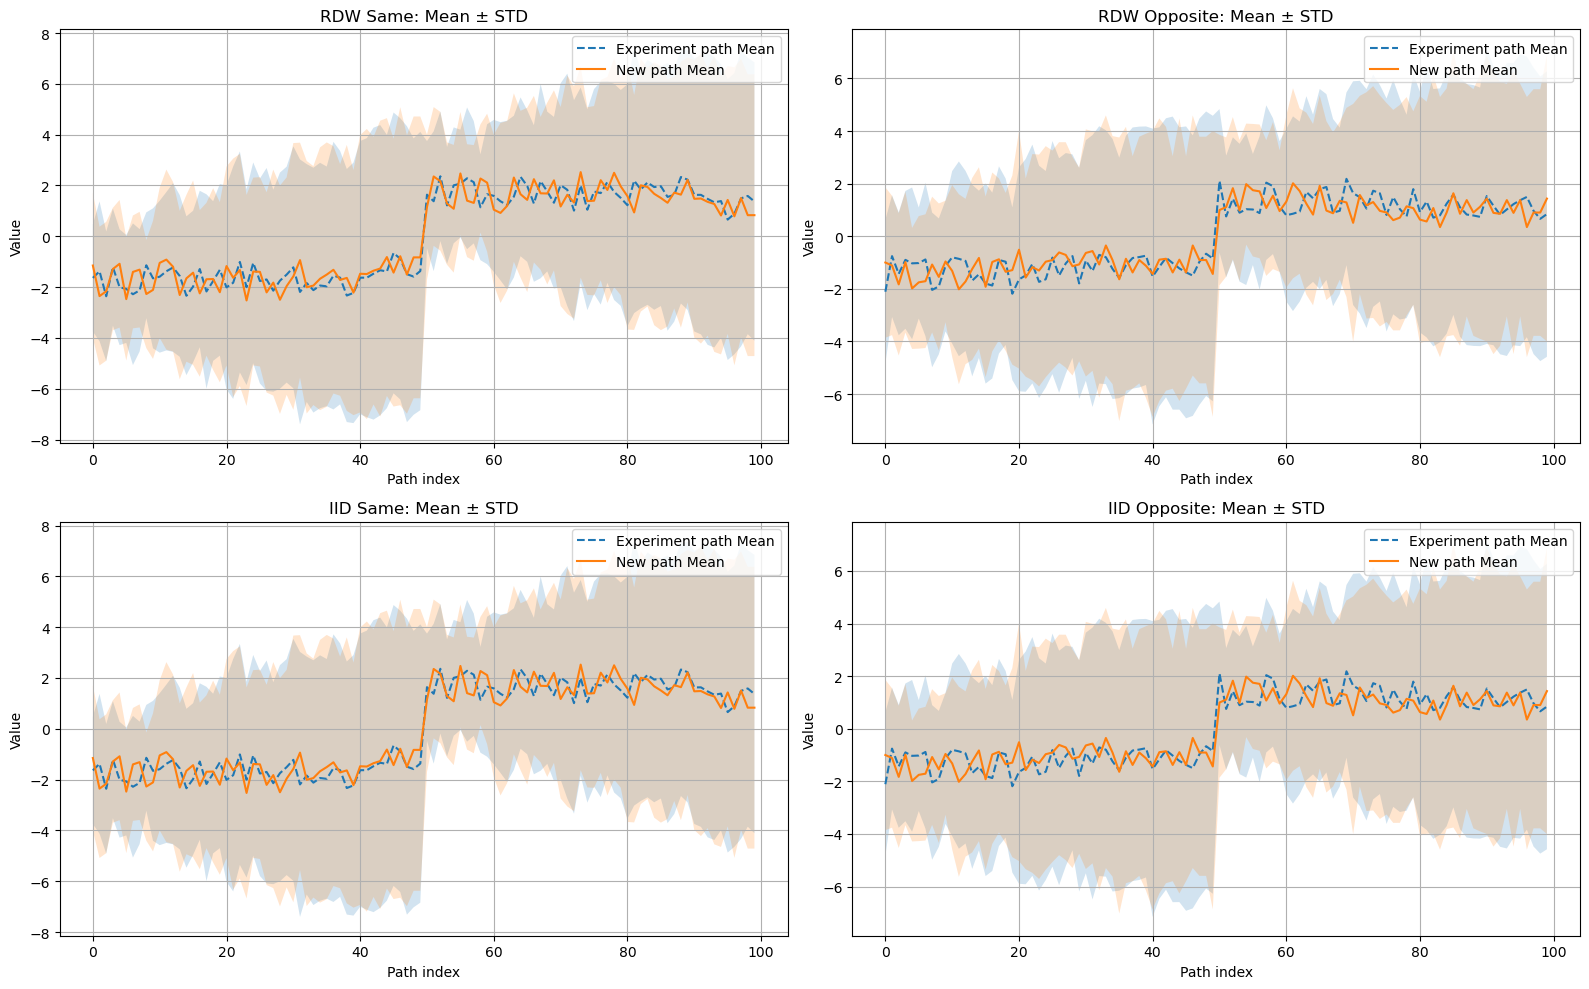

In [48]:
data_dict = {
    'RDW Same': (rdw_same_old, rdw_same_new),
    'RDW Opposite': (rdw_opp_old, rdw_op_new),
    'IID Same': (iid_same_old, iid_same_new),
    'IID Opposite': (iid_opp_old, iid_op_new)
}

# Create 4 subplots for Mean ± STD
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, (label, (old, new)) in zip(axes, data_dict.items()):
    mean_old = np.mean(old, axis=0)
    mean_new = np.mean(new, axis=0)
    std_old = np.std(old, axis=0)
    std_new = np.std(new, axis=0)

    ax.plot(mean_old, label=f'Experiment path Mean', linestyle='--')
    ax.plot(mean_new, label=f'New path Mean')
    ax.fill_between(range(len(mean_old)), mean_old - std_old, mean_old + std_old, alpha=0.2)
    ax.fill_between(range(len(mean_new)), mean_new - std_new, mean_new + std_new, alpha=0.2)
    ax.set_title(f'{label}: Mean ± STD')
    ax.set_xlabel('Path index')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [49]:
def mean_correlation(old, new):
    mean_old = np.mean(old, axis=0)
    mean_new = np.mean(new, axis=0)
    return np.corrcoef(mean_old, mean_new)[0, 1]

print("RDW Same corr:", mean_correlation(rdw_same_old, rdw_same_new))
print("RDW Opp corr:", mean_correlation(rdw_opp_old, rdw_op_new))
print("IID Same corr:", mean_correlation(iid_same_old, iid_same_new))
print("IID Opp corr:", mean_correlation(iid_opp_old, iid_op_new))


RDW Same corr: 0.9454400032237502
RDW Opp corr: 0.897081070520246
IID Same corr: 0.9454400032237504
IID Opp corr: 0.8970810705202462


In [11]:
for num in range(len(data_sim_rdw_same)):
    print(f' ###### RUN DATASET {num}: ######## ')
    rdw_same = data_sim_rdw_same[num]
    rdw_op= data_sim_rdw_op[num]
    iid_same = data_sim_iid_same[num]
    iid_op= data_sim_iid_op[num]
    
    rdw_same_t = process_paths(rdw_same)
    rdw_op_t = process_paths(rdw_op)   
    iid_same_t = process_paths(iid_same)
    iid_op_t = process_paths(iid_op)
    
    path_iid_same_interp_list = iid_same_t.copy()
    path_iid_op_interp_list = iid_op_t.copy()
    # Normalization
    scaled_list_iid_same, _, _,  = scaled_data2(path_iid_same_interp_list)  # Transpose for correct shape
    scaled_list_iid_op, _, _,  = scaled_data2(path_iid_op_interp_list)  # Transpose for correct shape
    
    ######### RDW ##########
    ##interpolation 
    #path_rdw_same_interp_list = list_to_interpolate_preserving_stats(rdw_same_t, output_size=150)
    #path_rdw_op_interp_list = list_to_interpolate_preserving_stats(rdw_op_t, output_size=150)
    path_rdw_same_interp_list = rdw_same_t.copy()
    path_rdw_op_interp_list = rdw_op_t.copy()
    ## Normalization
    scaled_list_rdw_same, _, _,  = scaled_data2(path_rdw_same_interp_list)  # Transpose for correct shape
    scaled_list_rdw_op, _, _,  = scaled_data2(path_rdw_op_interp_list)  # Transpose for correct shape
    
    X_iid_same= np.array(scaled_list_iid_same)
    X_rdw_same = np.array(scaled_list_rdw_same)
    
    X_iid_op= np.array(scaled_list_iid_op)
    X_rdw_op = np.array(scaled_list_rdw_op)
    
    X_iid_op_reshaped = X_iid_op.reshape(X_iid_op.shape[0], X_iid_op.shape[1], 1)
    X_rdw_op_reshaped = X_rdw_op.reshape(X_rdw_op.shape[0], X_rdw_op.shape[1], 1)
    
    X_iid_same_reshaped = X_iid_same.reshape(X_iid_same.shape[0], X_iid_same.shape[1], 1)
    X_rdw_same_reshaped = X_rdw_same.reshape(X_rdw_same.shape[0], X_rdw_same.shape[1], 1)
    
    print(X_iid_op_reshaped.shape), 
    print(X_iid_same_reshaped.shape)
    print(X_rdw_op_reshaped.shape), 
    print(X_rdw_same_reshaped.shape)
    
    window_size = 10 
    X_iid_same_recent = create_recent_points_data(X_iid_same_reshaped, window_size)
    X_rdw_same_recent = create_recent_points_data(X_rdw_same_reshaped, window_size)
    
    X_iid_op_recent = create_recent_points_data(X_iid_op_reshaped, window_size)
    X_rdw_op_recent = create_recent_points_data(X_rdw_op_reshaped, window_size)
    
    
    print("Shape of X_rdw_same_recent:", X_rdw_same_recent.shape)  #  (path*nsubj, window_size, 1)
    print("Shape of X_rdw_op_recent:", X_rdw_op_recent.shape)  #  (path*nsubj, window_size, 1)
    
    predicted_rt_all = {}
    side_pred_all = {}
    df_results_all = {}
    
    #datasets_rt = [
    #    ("iid same", X_iid_same_reshaped, X_iid_same_recent),
    #    ("iid opposite", X_iid_op_reshaped, X_iid_op_recent),
    #    ("rdw same", X_rdw_same_reshaped, X_rdw_same_recent),
    #    ("rdw opposite", X_rdw_op_reshaped, X_rdw_op_recent)
    #]
    datasets_rt = [
        ("iid same", X_iid_same_reshaped, X_iid_same_recent),
        ("iid opposite", X_iid_op_reshaped, X_iid_op_recent),
        ("rdw same", X_rdw_same_reshaped, X_rdw_same_recent),
        ("rdw opposite", X_rdw_op_reshaped, X_rdw_op_recent)
    ]

    
    for name, X_full, X_recent in datasets_rt:
        print(f"Predicting for {name}")
        
        predictions = model_combined_full.predict({'full_trajectory': X_full, 'recent_trajectory': X_recent})
        
        predicted_rt = predictions[1]
        side_pred = (predictions[0] >= 0.5).astype(int)
        side_pred_all[name] = side_pred
        predicted_rt_all[name] = predicted_rt
    
        normative_sides = []
        mean_nonzero_all = []
        last_visible_all = []
        mean_last_10pct_all = []
        acc_10_list = []
    
        for i, traj in enumerate(X_full):
            traj = traj.squeeze()
    
            mask = traj != 0
            mask[0] = True
            mean_nonzero = np.mean(traj[mask])
            mean_nonzero_all.append(mean_nonzero)
    
            visible = traj[traj != 0]
            last_visible = visible[-1] if len(visible) > 0 else 0
            last_visible_all.append(last_visible)
    
            
            if len(visible) >= 1:
                k = max(1, int(0.1 * len(visible)))
                mean_last_10pct = np.mean(visible[-k:])
            else:
                mean_last_10pct = 0  # fallback
            mean_last_10pct_all.append(mean_last_10pct)
    
            if "iid" in name:
                value = mean_nonzero
            else:  # RDW
                value = last_visible
            normative_side = 1 if value < 0 else 0
            normative_sides.append(normative_side)
    
            
            side_10 = 1 if mean_last_10pct < 0 else 0
            acc_10 = int(side_pred[i] == side_10)
            acc_10_list.append(acc_10)
        condition = name.replace(" ", "_")
        normative_sides = np.array(normative_sides)
        acc = (side_pred.squeeze() == normative_sides).astype(int)
    
        df_results_all[name] = pd.DataFrame({
            '# rt': np.array(np.abs(predicted_rt)).reshape(-1),
            'mean_nonzero': np.array(mean_nonzero_all).reshape(-1),
            'condition': np.array([condition]*100),
            'last_visible': np.array(last_visible_all).reshape(-1),
            'mean_last_10pct': np.array(mean_last_10pct_all).reshape(-1),
            'normative_side': normative_sides.reshape(-1),
            'predicted_side': side_pred.reshape(-1),
            'acc': acc.reshape(-1),
            'acc_10': np.array(acc_10_list).reshape(-1)
        })
    
    
    os.makedirs("../data/lstm_outputs_new_path_46_2", exist_ok=True)
    
    for name, df in df_results_all.items():
        
        condition = name.replace(" ", "_")
        filename = f"../data/lstm_outputs_new_path_46_2/lstm_pred_on_new_{condition}_{num}.csv"
        
        df.to_csv(filename, sep='\t',index=False)

 ###### RUN DATASET 0: ######## 
(100, 150, 1)
(100, 150, 1)
(100, 150, 1)
(100, 150, 1)
Shape of X_rdw_same_recent: (100, 10, 1)
Shape of X_rdw_op_recent: (100, 10, 1)
Predicting for iid same
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Predicting for iid opposite
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Predicting for rdw same
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Predicting for rdw opposite
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
 ###### RUN DATASET 1: ######## 
(100, 150, 1)
(100, 150, 1)
(100, 150, 1)
(100, 150, 1)
Shape of X_rdw_same_recent: (100, 10, 1)
Shape of X_rdw_op_recent: (100, 10, 1)
Predicting for iid same
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Predicting for iid opposite
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicting for rdw same
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Predicting for rdw opposite
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
 ###### RUN DATASET 2: ######## 
(100, 150, 1)
(100, 150, 1)
(100, 150, 1)
(100, 150, 1)
Shape of X_rdw_same_recent: (100, 10, 1)
Shape of X_rdw_op_re

In [35]:
one_rt_pred_iid_same = df_results_all['iid same']['# rt'].values
one_rt_pred_iid_opp = df_results_all['iid opposite']['# rt'].values


one_rt_pred_rdw_same = df_results_all['rdw same']['# rt'].values
one_rt_pred_rdw_opp = df_results_all['rdw opposite']['# rt'].values